#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [27]:
# Testing if integration works

In [39]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
from fastmri import evaluate
import torch

Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

# Masked Testing Data

In [116]:
test_data = '../data/singlecoil_val/file1000000.h5'
hf = h5py.File(test_data)
#file_name2 = '../data/singlecoil_test/file1000022.h5'
#file_name3 = '../data/singlecoil_test/file1000055.h5'
#hf2 = h5py.File(file_name2)
#hf3 = h5py.File(file_name3)

In [117]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPDFS_FBK', 'max': 0.00017707173297391214, 'norm': 0.058663394182755665, 'patient_id': 'b2a82c7521fe2d4aebb627bbaae92a1916bf06e75cb374fc4187b0909e5c0e36'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [118]:
volume_kspace = hf['kspace'][()]
#volume_kspace2 = hf2['kspace'][()]
#volume_kspace3 = hf3['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(35, 640, 368)


In [119]:
slice_kspace = volume_kspace

Let's see what the absolute value of k-space looks like:

In [120]:
def show_multiple_slices(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [121]:
#def show_slice(data, cmap=None):
    #fig = plt.figure()
    #plt.imshow(data, cmap=cmap)

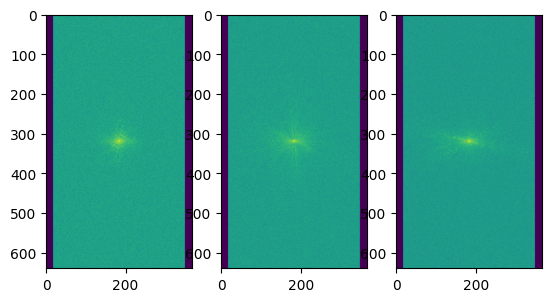

In [122]:
show_multiple_slices(np.log(np.abs(slice_kspace) + 1e-9), [10,20,30]) #show the 10th, 20th, and 30th slices

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [123]:
import fastmri
from fastmri.data import transforms as T

In [124]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

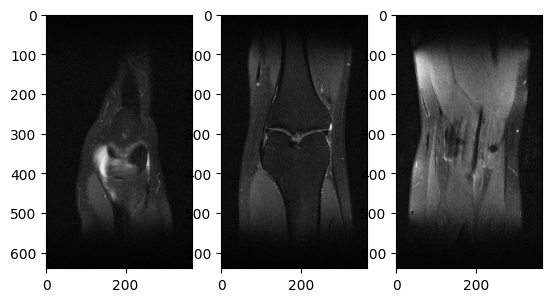

In [125]:
show_multiple_slices(slice_image_abs, [10,20,30], cmap='gray')

MR imaging is an indirect process, whereby cross-sectional images of the subject’s anatomy are
produced from frequency and phase measurements instead of direct, spatially-resolved measurements. As we can see, each image in the dataset focuses on a different snapshot of the subject's anatomy. These slices can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [126]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

# Before Reconstruction

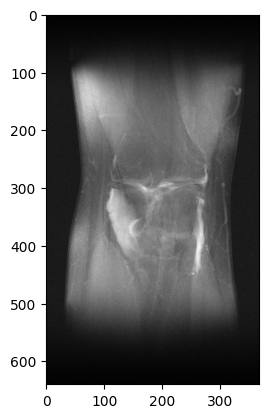

In [127]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

# After Reconstruction

In [128]:
reconstructed = 'fastmri_examples/unet/output_val/reconstructions/file1000000.h5'
hf_r = h5py.File(reconstructed)

In [129]:
print('Keys:', list(hf_r.keys()))
print('Attrs:', dict(hf_r.attrs))

Keys: ['reconstruction']
Attrs: {}


In [130]:
volume_kspace_r = torch.tensor(hf_r['reconstruction'][()].squeeze(1))
print(volume_kspace_r.dtype)
print(volume_kspace_r.shape)

torch.float32
torch.Size([35, 320, 320])


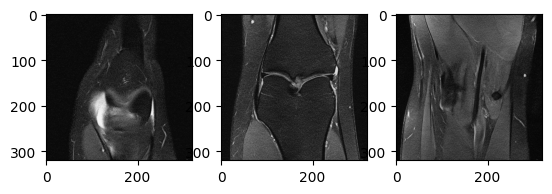

In [131]:
show_multiple_slices(volume_kspace_r, [10,20,30], cmap='gray') #show the 10th, 20th, and 30th slices

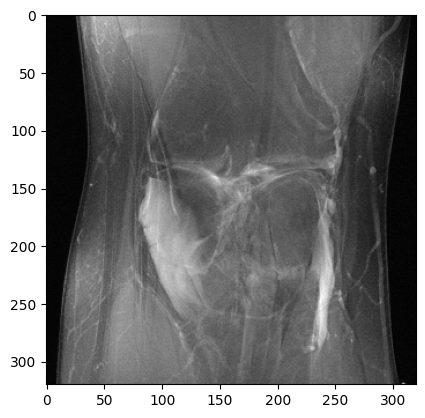

In [132]:
slice_image_rss = fastmri.rss(volume_kspace_r, dim=0)
plt.imshow(np.abs(slice_image_rss), cmap='gray')

# Simulating Under-Sampled Data

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [147]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [148]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [149]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

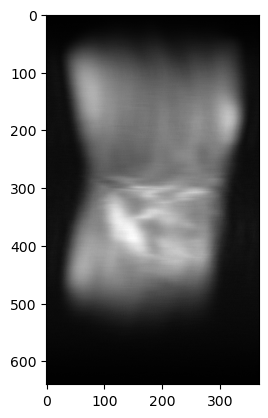

In [150]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

# Calculating Reconstruction Error (NMSE, PSNR, SSIM)

In [171]:
import os
# assign directory
directory = 'fastmri_examples/unet/output_val/reconstructions'

nmse = []
psnr = []
ssim = []

# iterate over files in
# that directory
for filename in os.listdir(directory):

    #validation image (the original)
    val_image = f'../data/singlecoil_val/{filename}'
    hf = h5py.File(val_image)
    val_kspace = hf['kspace'][()]
    slice_kspace2 = T.to_tensor(val_kspace)      # Convert from numpy array to pytorch tensor
    slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
    slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
    slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
    length = slice_image_abs.shape[1]
    width = slice_image_abs.shape[2]
    pad_l = (length - 320)//2
    pad_w = (width - 320)//2
    true_image = slice_image_abs[:,pad_l:(length-pad_l), pad_w:(width-pad_w)]
    
    #reconstructed image
    recon_image = f'fastmri_examples/unet/output_val/reconstructions/{filename}'
    recon_hf = h5py.File(recon_image)
    pred_image = torch.tensor(recon_hf['reconstruction'][()].squeeze(1))

    #nmse
    nmse.append(evaluate.nmse(true_image.numpy(), pred_image.numpy()))
    
    #psnr
    psnr.append(evaluate.psnr(true_image.numpy(), pred_image.numpy()))
    
    #ssmr
    ssim.append(evaluate.ssim(true_image.numpy(), pred_image.numpy()))
    

In [172]:
print("Mean NMSE:", np.mean(nmse))
print("Mean PSNR:", np.mean(psnr))
print("Mean SSIM:", np.mean(ssim))

Mean NMSE: 0.01995782156780105
Mean PSNR: 34.24053906923211
Mean SSIM: 0.92829765640603
